# Goal of phase 2:
Use the dataset from phase 1 to develop a predictive model for blood-brain-barrier penetration using Logistic Regression (scikit-learn), after reducing the number of descriptors used to 20, based on Recursive Feature Elimination (scikit-learn)

## Import libraries needed

In [1]:
from pip._internal import main as pip

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import sklearn
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt
    
try:
    from jaqpotpy import Jaqpot
except ImportError:
    pip(['install', 'jaqpotpy'])
    from jaqpotpy import Jaqpot

### Starting from the dataset created in phase 1. 
For this step we need a modellable dataset (You get what you give). After the workshop, you can try with you own datasets and create your own web services for your models.

In [3]:
df = pd.read_csv('compounds_descriptors.csv', index_col=None)

In [4]:
# remove constant columns - they cannot be scaled
df = df.loc[:, (df != df.iloc[0]).any()] 

#### Split the main dataframe into X and Y

In [5]:
X = df.drop(['True', 'SMILES'], axis=1)
Y = df[['True']].replace({'non-penetrating': 0, 'penetrating': 1})

#### Scaling between 0 and 1

In [6]:
X_scaled = (X - X.min()) / (X.max() - X.min())

#### Select only 20 most important features
More here: Recursive Feature Elimination (scikit-learn)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [7]:
model = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=100) 

rfe = RFE(model, 20, verbose=1)
fit = rfe.fit(X_scaled, Y['True'])

X_rfe = X_scaled.loc[:, fit.support_.tolist()]

Fitting estimator with 748 features.
Fitting estimator with 747 features.
Fitting estimator with 746 features.
Fitting estimator with 745 features.
Fitting estimator with 744 features.
Fitting estimator with 743 features.
Fitting estimator with 742 features.
Fitting estimator with 741 features.
Fitting estimator with 740 features.
Fitting estimator with 739 features.
Fitting estimator with 738 features.
Fitting estimator with 737 features.
Fitting estimator with 736 features.
Fitting estimator with 735 features.
Fitting estimator with 734 features.
Fitting estimator with 733 features.
Fitting estimator with 732 features.
Fitting estimator with 731 features.
Fitting estimator with 730 features.
Fitting estimator with 729 features.
Fitting estimator with 728 features.
Fitting estimator with 727 features.
Fitting estimator with 726 features.
Fitting estimator with 725 features.
Fitting estimator with 724 features.
Fitting estimator with 723 features.
Fitting estimator with 722 features.
F

#### Cross-validation of logistic regression model
More here: Recursive Feature Elimination (scikit-learn)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [8]:
model = LogisticRegressionCV(Cs=100, class_weight=None,
            cv=5, dual=False, fit_intercept=True, intercept_scaling=1.0, 
            max_iter=10000, multi_class='ovr', n_jobs=1, penalty='l1', 
            random_state=None, refit=True, scoring='accuracy', 
            solver='liblinear', tol=0.0001, verbose=0).fit(X_rfe, Y['True'])

# get class predictions
df['Predicted'] = model.predict(X_rfe)

# get probabilities
dfProb = pd.DataFrame(model.predict_proba(X_rfe), columns=['Probability_N', 'Probability_P'])

dfJaqpot = df[['SMILES', 'True', 'Predicted']].replace({0: 'non-penetrating', 1: 'penetrating'})
dfJaqpot = pd.concat([dfJaqpot, dfProb], sort=False, axis=1)

dfJaqpot.to_csv('predictions_Jaqpot.csv', index=False)

#### Evaluate model performance
For more: 
Parikh, Rajul et al. “Understanding and using sensitivity, specificity and predictive values.” Indian journal of ophthalmology vol. 56,1 (2008): 45-50. doi:10.4103/0301-4738.37595

##### Confusion matrix

In [10]:
conf = pd.crosstab(dfJaqpot['True'], dfJaqpot['Predicted'])
conf

Predicted,non-penetrating,penetrating
True,,
non-penetrating,90,38
penetrating,25,235


##### Positive predictive value

In [18]:
tn, fp, fn, tp = confusion_matrix(dfJaqpot['True'], dfJaqpot['Predicted']).ravel()
    
ppv = tp / (tp + fp)
ppv

0.8608058608058609

##### Negative predictive value

In [19]:
npv = tn / (tn + fn)
npv

0.782608695652174

##### ROC plot

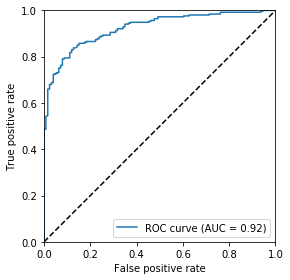

In [12]:
dfPlot = dfJaqpot.copy()

dfPlot = dfPlot.dropna(axis=0, how='any').drop_duplicates()

dfPlot['Probability_diff'] = (dfPlot['Probability_P'] - dfPlot['Probability_N']) # / 2. + 0.5
dfPlot['True'] = dfPlot['True'].replace({'penetrating': 1, 'non-penetrating': 0})

# compute ROC
fpr, tpr, thresholds = metrics.roc_curve(dfPlot['True'], dfPlot['Probability_diff'], pos_label=1)

# compute AUC
auc = metrics.auc(fpr, tpr)

# prepare the plot
fig, ax = plt.subplots(1, 1)

ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
ax.plot([0,1], [0,1], label='', color='black', linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

fig.tight_layout()

plt.show()

## Deploy the model to Jaqpot service

In [28]:
# URL to access the jaqpot service
jaqpot = Jaqpot("https://api-jaqpot.prod.openrisknet.org/jaqpot/services/")

#alternative link for Jaqpot services
#jaqpot = Jaqpot("https://api.jaqpot.org/jaqpot/services/")

### Authentication
You can authenticate yourself either through username/password (have to entered everytime) or with API key obtained from the Jaqpot website (requires login and has validity for a limited time - does not have to entered everytime)

In [ ]:
#with username/password
jaqpot.request_key_safe()

#with API key 
#apiKey = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJoX2p2Z3I3bWZ4VGJ3OHJLNW9Fb3dWWUVHUms2Z0hsLW9sSjdPUnQ3V2QwIn0.eyJqdGkiOiJkYTU0ZWEwYS1kMGExLTRhY2YtYmFmNC04NWRmZjRiOGJmNTQiLCJleHAiOjE1NzA4MzM0NDYsIm5iZiI6MCwiaWF0IjoxNTcwODMyNTQ2LCJpc3MiOiJodHRwczovL3Nzby5wcm9kLm9wZW5yaXNrbmV0Lm9yZy9hdXRoL3JlYWxtcy9vcGVucmlza25ldCIsImF1ZCI6ImFjY291bnQiLCJzdWIiOiI1NmUyNjk0MS0wMjk1LTRiNmUtOTRmOS03OWY3OWZiY2Y5NmMiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJqYXFwb3QtdWkiLCJub25jZSI6Ik4wLjM4NTU2MTk2MTA3NDc3NDUxNTcwODMyNTQzMDkyIiwiYXV0aF90aW1lIjoxNTcwODMyNTQ2LCJzZXNzaW9uX3N0YXRlIjoiYTcyYzk2NDgtNWEwNC00NDNlLTkwODQtZDJmNTU3MzM1MWM3IiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJzdGFuZGFyZC11c2VyIiwib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZW1haWwiLCJlbWFpbF92ZXJpZmllZCI6ZmFsc2UsIm5hbWUiOiJ0b21heiBtb2hvcmljIiwicHJlZmVycmVkX3VzZXJuYW1lIjoidG1vaG9yaWMiLCJnaXZlbl9uYW1lIjoidG9tYXoiLCJmYW1pbHlfbmFtZSI6Im1vaG9yaWMiLCJlbWFpbCI6Im1vaG9yaWMudG9tYXpAZ21haWwuY29tIn0.KXdZaA-xHJeC9QczFyRUhkSGddZLNas-HeiZUcQ0SDdM8GpkNkFthWzzT2kaPOluF3X43iJDoufLJgG16vbl9aCRiIOp_rRP-TITCupu4Ta_AdefdDy7O5Gz_mRbMgSZHplVtmGtSrBqNIvMcmVXcpohPkCkbK-xujak_ZqPNiCVXpb2VWjfTxa-qxb3AcvC7uEzWLBkd4ORYYUjvCTJGSkJdtd5OcMvkv7hutB5YMKSJw-I6-FXL0yFTu4bBVY-qSLfGoaZa1D4JSRdrF8EBHJ0IKGELzk5abSZ2CB4dsKz-lNa71PmjIIOrUxJl5h9qEjGDgUvytl4nX2zoJg9kg"
#jaqpot.set_api_key(apiKey)

## From model to web service in 1 line of code

In [ ]:
# deploy the model to jaqpot
url = jaqpot.deploy_linear_model(model, X_rfe, Y[['True']], title="OpenRiskNet/ModelRX", description="Logistic regression model + RFE", algorithm="logistic regression")

You now have a web service.

In [32]:
print(url)

yHGXGAVrxsmui0nnXU3S


In [33]:
X_rfe.columns

Index(['nAcid', 'MATS1p', 'GATS1se', 'nBondsD', 'RPCG', 'NssssN', 'SssssN',
       'SddssS', 'IC1', 'Lipinski', 'PEOE_VSA3', 'PEOE_VSA8', 'PEOE_VSA11',
       'SlogP_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA5',
       'VSA_EState8', 'n7HRing', 'n6FRing'],
      dtype='object')



You can also get predictions from your model:

In [ ]:
pred, predCol = jaqpot.predict(X_rfe, modelId=url)

In [35]:
pred

,NssssN,PEOE_VSA3,nAcid,SlogP_VSA10,MATS1p,nBondsD,EState_VSA2,GATS1se,SddssS,RPCG,...,IC1,Lipinski,VSA_EState8,EState_VSA3,PEOE_VSA8,SssssN,True,n6FRing,EState_VSA5,n7HRing
0,0,0.177288,0.0,0.000000,0.525334,0.066667,0.274539,0.336161,1.000000,0.103911,...,0.982863,1,0.217271,0.618710,0.103425,0.0,1,0,0.202844,1
1,0,0.177288,0.0,0.000000,0.535277,0.000000,0.000000,0.572574,1.000000,0.166547,...,0.706634,1,0.199741,0.146389,0.276103,0.0,1,0,0.000000,0
2,0,0.177288,0.0,0.000000,0.535277,0.000000,0.000000,0.572574,1.000000,0.166547,...,0.706634,1,0.199741,0.146389,0.276103,0.0,1,0,0.000000,0
3,0,0.000000,0.0,0.185059,0.554742,0.066667,0.000000,0.515808,1.000000,0.234713,...,0.677722,1,0.708066,0.128601,0.273874,0.0,1,0,0.635761,0
4,0,0.333461,0.0,0.142857,0.542120,0.066667,0.129238,0.198597,1.000000,0.124416,...,0.806137,1,0.402696,0.821144,0.612203,0.0,0,0,0.208147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0.000000,0.0,0.000000,0.654844,0.000000,0.000000,0.487902,1.000000,0.287190,...,0.682089,1,0.419335,0.402348,0.353050,0.0,1,0,0.000000,0
384,0,0.476721,0.0,0.189304,0.512897,0.266667,0.307252,0.215919,0.513168,0.154092,...,0.955968,1,0.169934,0.000000,0.194363,0.0,0,0,0.331294,0
385,0,0.000000,0.0,0.000000,0.643280,0.000000,0.128742,0.452737,1.000000,0.099241,...,0.599099,0,0.604214,0.000000,0.000000,0.0,1,0,0.095446,0
386,0,0.000000,0.0,0.000000,0.725519,0.133333,0.192371,0.246524,1.000000,0.210130,...,0.508553,1,0.386176,0.261724,0.094226,0.0,1,0,0.536229,0
